In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import joblib as jl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedShuffleSplit

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

root = 'dl'

Using TensorFlow backend.


# Load raw data

In [2]:
labels = pd.read_csv('../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv', header=0).rename({'Unnamed: 0': 'PIN'}, axis=1)[['PIN', 'CLASS']].set_index('PIN')
labels.head()

,CLASS
PIN,
568483,1
923748,0
2035328,0
2239386,1
2244533,1


In [13]:
# data = jl.load(open('../../tmp/item_days_raw_data_.pkl', 'rb')).loc[labels.index, 'seq']
data = pd.read_csv('../../tmp/raw_sequences.csv', header=0, index_col=0).loc[labels.index, 'seq']
df = pd.DataFrame(columns=['Seq', 'Class'], index=data.index)
df.loc[:, 'Seq'] = data
df.loc[:, 'Class'] = labels['CLASS']
df.head()

,Seq,Class
PIN,,
568483,10990 0 23 1 725 0 10990 0 10990 0 10990 0 109...,1
923748,66653 0 65070 0 66515 0 10962 0 105 0 56807 2 ...,0
2035328,66536 0 74995 0 66512 0 66551 0 66608 0 66716 ...,0
2239386,10991 0 23 3 73928 0 66560 0 66515 0 66551 0 6...,1
2244533,10990 0 23 2 23 0 10990 0 73928 0 66500 0 6656...,1


# Separate MBS items and timepoints

In [14]:
for idx in df.index:
    _tmp = df.loc[idx, 'Seq'].split(' ')
    df.loc[idx, 'mbs_seq'] = ' '.join(_tmp[::2])
    df.loc[idx, 'times_seq'] = ' '.join(_tmp[1::2])

In [15]:
df.head()

,Seq,Class,mbs_seq,times_seq
PIN,,,,
568483,10990 0 23 1 725 0 10990 0 10990 0 10990 0 109...,1,10990 23 725 10990 10990 10990 10993 23 85311 ...,0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 ...
923748,66653 0 65070 0 66515 0 10962 0 105 0 56807 2 ...,0,66653 65070 66515 10962 105 56807 10990 23 109...,0 0 0 0 0 2 0 1 2 0 0 0 0 0 0 0 0 0 0 0 1 2 1 ...
2035328,66536 0 74995 0 66512 0 66551 0 66608 0 66716 ...,0,66536 74995 66512 66551 66608 66716 66560 7392...,0 0 0 0 0 0 0 0 0 0 0 3 0 0 2 1 2 0 0 0 0 0 0 ...
2239386,10991 0 23 3 73928 0 66560 0 66515 0 66551 0 6...,1,10991 23 73928 66560 66515 66551 66536 2517 10...,0 3 0 0 0 0 0 0 1 0 0 0 0 1 3 0 0 0 0 0 0 2 0 ...
2244533,10990 0 23 2 23 0 10990 0 73928 0 66500 0 6656...,1,10990 23 23 10990 73928 66500 66560 66551 23 1...,0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


# Seq2Tokens

In [20]:
# Define tokenizer object
tokenizer = Tokenizer(char_level=False, lower=False, split=' ')

# Fit on corpus and extract tokenized sequences
tokenizer.fit_on_texts(df['mbs_seq'])
n_feat = len(tokenizer.word_index.keys())
print(n_feat)
seq = tokenizer.texts_to_sequences(df['mbs_seq'])

# Pad tokenized sequences
lengths = [len(x) for x in seq]
maxlen = int(np.percentile(lengths, 95))
p_seq = pad_sequences(seq, maxlen=maxlen)
print(p_seq.shape)

2773
(11744, 445)


# Training - Validation - Test split

In [21]:
# Full dataset
y = df['Class'].ravel()
X = p_seq

# Learn / Test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
learn_idx, test_idx = next(sss.split(X, y))

X_learn, y_learn = X[learn_idx, :], y[learn_idx]
X_test, y_test = X[test_idx, :], y[test_idx]

print('{} learn / {} test'.format(len(y_learn), len(y_test)))

# Training / Validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=1)
train_idx, valid_idx = next(sss.split(X_learn, y_learn))

X_train, y_train = X_learn[train_idx, :], y_learn[train_idx]
X_valid, y_valid = X_learn[valid_idx, :], y_learn[valid_idx]

print('{} training / {} validation'.format(len(y_train), len(y_valid)))

5872 learn / 5872 test
5284 training / 588 validation


# Init embedding matrix

In [31]:
D = 50
embedding = pd.read_csv('../../tmp/embedding.{}d.csv'.format(D), header=0, index_col=0)
embedding_matrix = embedding.values

# Model \#1: Embedding + Dense (overfitting like crazy)

In [30]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

model = Sequential()
model.add(Embedding(n_feat, D, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.05)))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 445, 50)           138650    
_________________________________________________________________
flatten_4 (Flatten)          (None, 22250)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 22251     
Total params: 160,901
Trainable params: 160,901
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [33]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

history = model.fit(X_train, y_train,
                    epochs=500,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/500
5284/5284 [==============================] - 1s 129us/step - loss: 0.8726 - acc: 0.4886 - val_loss: 0.7443 - val_acc: 0.5000
Epoch 2/500
5284/5284 [==============================] - 0s 53us/step - loss: 0.7443 - acc: 0.5276 - val_loss: 0.8172 - val_acc: 0.5000
Epoch 3/500
5284/5284 [==============================] - 0s 49us/step - loss: 0.7201 - acc: 0.5397 - val_loss: 0.6894 - val_acc: 0.6684
Epoch 4/500
5284/5284 [==============================] - 0s 51us/step - loss: 0.6871 - acc: 0.5999 - val_loss: 0.7730 - val_acc: 0.5000
Epoch 5/500
5284/5284 [==============================] - 0s 50us/step - loss: 0.6723 - acc: 0.6382 - val_loss: 0.6708 - val_acc: 0.6701
Epoch 6/500
5284/5284 [==============================] - 0s 51us/step - loss: 0.6509 - acc: 0.6898 - val_loss: 0.6852 - val_acc: 0.6071
Epoch 7/500
5284/5284 [==============================] - 0s 52us/step - loss: 0.6327 - acc: 0.7197 - val_loss: 0.6472 - val_acc: 0.7041


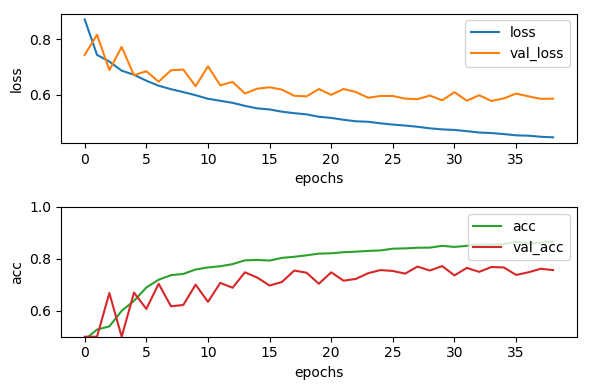

In [34]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_dense.png')

In [35]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 0s 73us/step
test_loss: 0.5728 - test_acc: 0.7687


In [10]:
# model.save_weights('embedding_dense.h5')

# Model \#3: Embedding + LSTM

In [44]:
from keras.layers import CuDNNLSTM

model = Sequential()
model.add(Embedding(n_feat, D, input_length=maxlen))
model.add(CuDNNLSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 445, 50)           138650    
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 32)                10752     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 149,435
Trainable params: 149,435
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

In [46]:
callbacks = [EarlyStopping(monitor='val_loss', patience=7)]

history = model.fit(X_train, y_train,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/100
5284/5284 [==============================] - 3s 551us/step - loss: 0.6861 - acc: 0.5587 - val_loss: 0.6792 - val_acc: 0.5374
Epoch 2/100
5284/5284 [==============================] - 2s 454us/step - loss: 0.6321 - acc: 0.6514 - val_loss: 0.5923 - val_acc: 0.7058
Epoch 3/100
5284/5284 [==============================] - 2s 451us/step - loss: 0.5819 - acc: 0.6963 - val_loss: 0.5895 - val_acc: 0.7041
Epoch 4/100
5284/5284 [==============================] - 2s 451us/step - loss: 0.5476 - acc: 0.7233 - val_loss: 0.5441 - val_acc: 0.7347
Epoch 5/100
5284/5284 [==============================] - 2s 450us/step - loss: 0.5151 - acc: 0.7428 - val_loss: 0.5145 - val_acc: 0.7449
Epoch 6/100
5284/5284 [==============================] - 2s 449us/step - loss: 0.5037 - acc: 0.7555 - val_loss: 0.4859 - val_acc: 0.7602
Epoch 7/100
5284/5284 [==============================] - 2s 450us/step - loss: 0.4774 - acc: 0.7667 - val_loss: 0.5132 - val_acc: 0

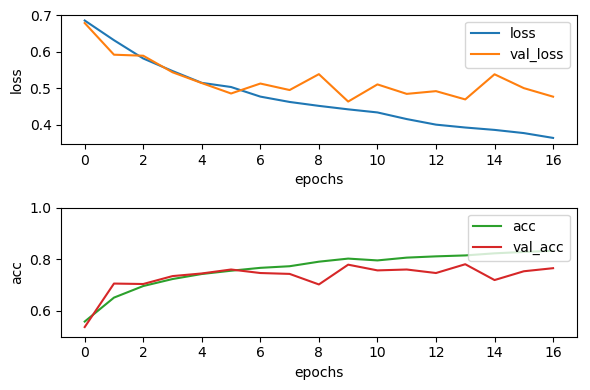

In [47]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_LSTM.png')

In [48]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 4s 653us/step
test_loss: 0.4665 - test_acc: 0.7750


In [49]:
model.save_weights(root+'lstm.h5')

# Model \#4: Embedding + Conv1D + LSTM

In [55]:
from keras.layers import Conv1D

model = Sequential()
model.add(Embedding(n_feat, D, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu'))
model.add(CuDNNLSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 445, 50)           138650    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 441, 64)           16064     
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 32)                12544     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 167,291
Trainable params: 167,291
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

In [57]:
callbacks = [EarlyStopping(monitor='val_loss', patience=7)]

history = model.fit(X_train, y_train,
                    epochs=300,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/300
5284/5284 [==============================] - 3s 614us/step - loss: 0.6899 - acc: 0.5534 - val_loss: 0.6687 - val_acc: 0.6735
Epoch 2/300
5284/5284 [==============================] - 3s 513us/step - loss: 0.6261 - acc: 0.6635 - val_loss: 0.5710 - val_acc: 0.7296
Epoch 3/300
5284/5284 [==============================] - 3s 512us/step - loss: 0.5614 - acc: 0.7116 - val_loss: 0.5638 - val_acc: 0.7041
Epoch 4/300
5284/5284 [==============================] - 3s 513us/step - loss: 0.5207 - acc: 0.7417 - val_loss: 0.5174 - val_acc: 0.7398
Epoch 5/300
5284/5284 [==============================] - 3s 511us/step - loss: 0.4840 - acc: 0.7648 - val_loss: 0.4795 - val_acc: 0.7704
Epoch 6/300
5284/5284 [==============================] - 3s 513us/step - loss: 0.4481 - acc: 0.7888 - val_loss: 0.5005 - val_acc: 0.7619
Epoch 7/300
5284/5284 [==============================] - 3s 512us/step - loss: 0.4183 - acc: 0.8024 - val_loss: 0.4971 - val_acc: 0

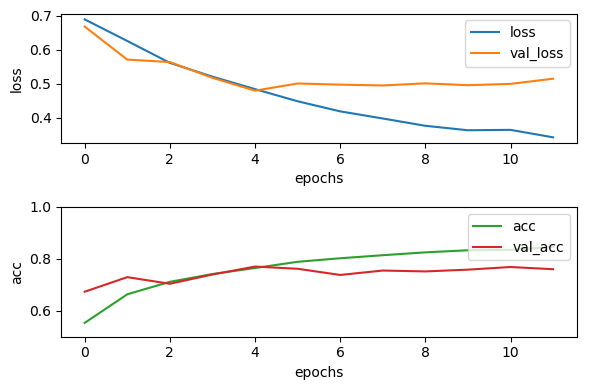

In [58]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_convLSTM.png')

In [59]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 4s 670us/step
test_loss: 0.5230 - test_acc: 0.7635


In [60]:
model.save_weights(root+'conv_lstm.h5')

# Model \#7: Embedding + BiLSTM

In [62]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(n_feat, D, input_length=maxlen))
model.add(Bidirectional(CuDNNLSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 445, 50)           138650    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                21504     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 160,219
Trainable params: 160,219
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

In [64]:
callbacks = [EarlyStopping(monitor='val_loss', patience=7)]

history = model.fit(X_train, y_train,
                    epochs=300,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/300
5284/5284 [==============================] - 5s 992us/step - loss: 0.6834 - acc: 0.5590 - val_loss: 0.6629 - val_acc: 0.5782
Epoch 2/300
5284/5284 [==============================] - 5s 881us/step - loss: 0.6351 - acc: 0.6470 - val_loss: 0.5940 - val_acc: 0.6973
Epoch 3/300
5284/5284 [==============================] - 5s 890us/step - loss: 0.5868 - acc: 0.6930 - val_loss: 0.5957 - val_acc: 0.6837
Epoch 4/300
5284/5284 [==============================] - 5s 892us/step - loss: 0.5572 - acc: 0.7161 - val_loss: 0.5732 - val_acc: 0.7024
Epoch 5/300
5284/5284 [==============================] - 5s 894us/step - loss: 0.5312 - acc: 0.7326 - val_loss: 0.8198 - val_acc: 0.6020
Epoch 6/300
5284/5284 [==============================] - 5s 896us/step - loss: 0.5135 - acc: 0.7424 - val_loss: 0.6067 - val_acc: 0.6650
Epoch 7/300
5284/5284 [==============================] - 5s 892us/step - loss: 0.4885 - acc: 0.7597 - val_loss: 0.5018 - val_acc: 0

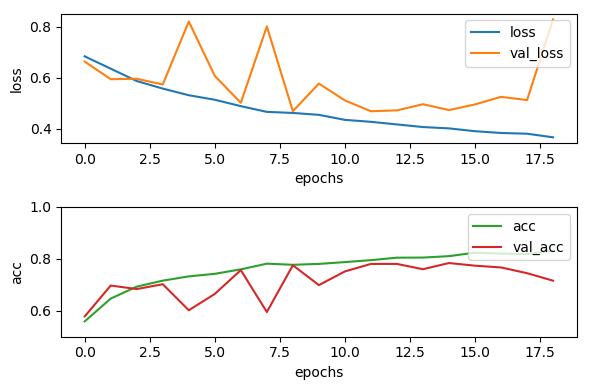

In [65]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'embedding_bilstm.png')

In [66]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 7s 1ms/step
test_loss: 0.8755 - test_acc: 0.7011


In [67]:
# model.save_weights('embedding_bilstm.h5')

# Model \#8: Embedding + Conv1D + BiLSTM

In [68]:
from keras.optimizers import Adam
from keras.layers import MaxPooling1D

model = Sequential()
model.add(Embedding(n_feat, D, input_length=maxlen))
model.add(Conv1D(128, 10, activation='relu'))
model.add(MaxPooling1D(5, 1))
model.add(Bidirectional(CuDNNLSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',#Adam(lr=1e-5, decay=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 445, 50)           138650    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 436, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 432, 128)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41472     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 244,315
Trainable params: 244,315
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

In [70]:
callbacks = [EarlyStopping(monitor='val_loss', patience=7)] 

history = model.fit(X_train, y_train,
                    epochs=500,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/500
5284/5284 [==============================] - 7s 1ms/step - loss: 0.6967 - acc: 0.5337 - val_loss: 0.7367 - val_acc: 0.5000
Epoch 2/500
5284/5284 [==============================] - 6s 1ms/step - loss: 0.6452 - acc: 0.6306 - val_loss: 0.5981 - val_acc: 0.6837
Epoch 3/500
5284/5284 [==============================] - 6s 1ms/step - loss: 0.6020 - acc: 0.6819 - val_loss: 0.5848 - val_acc: 0.6973
Epoch 4/500
5284/5284 [==============================] - 6s 1ms/step - loss: 0.5659 - acc: 0.7123 - val_loss: 0.5866 - val_acc: 0.6769
Epoch 5/500
5284/5284 [==============================] - 6s 1ms/step - loss: 0.5341 - acc: 0.7324 - val_loss: 0.5742 - val_acc: 0.6922
Epoch 6/500
5284/5284 [==============================] - 6s 1ms/step - loss: 0.5038 - acc: 0.7538 - val_loss: 0.5709 - val_acc: 0.7041
Epoch 7/500
5284/5284 [==============================] - 6s 1ms/step - loss: 0.4692 - acc: 0.7731 - val_loss: 0.5222 - val_acc: 0.7517
Epoch 8/

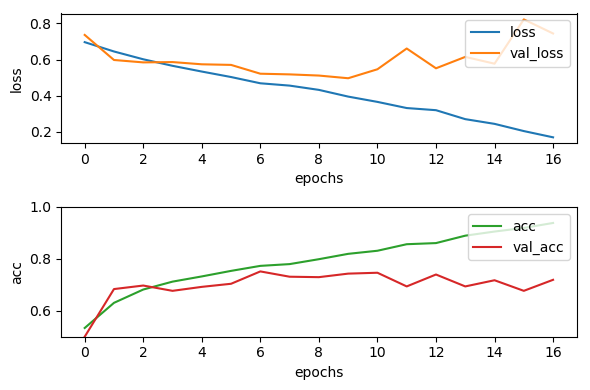

In [71]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_conv_bilstm.png')

In [72]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 8s 1ms/step
test_loss: 0.8000 - test_acc: 0.6860


# Model \#: 10

In [73]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(n_feat, D, input_length=maxlen))
model.add(Bidirectional(LSTM(32, recurrent_dropout=0.25, dropout=0.25)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 445, 50)           138650    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                21248     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 159,963
Trainable params: 159,963
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

In [75]:
callbacks = [EarlyStopping(monitor='val_loss', patience=15)] 

history = model.fit(X_train, y_train,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/100
5284/5284 [==============================] - 70s 13ms/step - loss: 0.6918 - acc: 0.5254 - val_loss: 0.6856 - val_acc: 0.5068
Epoch 2/100
5284/5284 [==============================] - 66s 13ms/step - loss: 0.6706 - acc: 0.6028 - val_loss: 0.6399 - val_acc: 0.6565
Epoch 3/100
5284/5284 [==============================] - 68s 13ms/step - loss: 0.6320 - acc: 0.6531 - val_loss: 0.6118 - val_acc: 0.6769
Epoch 4/100
5284/5284 [==============================] - 68s 13ms/step - loss: 0.6030 - acc: 0.6760 - val_loss: 0.5735 - val_acc: 0.7160
Epoch 5/100
5284/5284 [==============================] - 68s 13ms/step - loss: 0.5852 - acc: 0.6953 - val_loss: 0.5737 - val_acc: 0.7075
Epoch 6/100
5284/5284 [==============================] - 67s 13ms/step - loss: 0.5677 - acc: 0.7116 - val_loss: 0.5520 - val_acc: 0.7432
Epoch 7/100
5284/5284 [==============================] - 67s 13ms/step - loss: 0.5524 - acc: 0.7178 - val_loss: 0.5419 - val_acc: 0

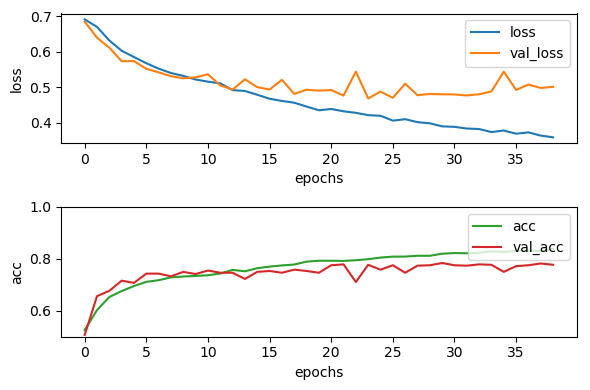

In [76]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_dropout_LSTM.png')

In [77]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 61s 10ms/step
test_loss: 0.5080 - test_acc: 0.7737
